In [1]:
#import libraries
import easyocr
import cv2
import time
import re
import matplotlib.pyplot as plt

---
This code is a set of functions that are used to process an image and extract certain information from it using Optical Character Recognition (OCR).

* `sort_detections` : sorts a list of detections based on the average y-coordinate of each detection's bounding box.

* `group_detections` : groups the sorted detections based on a threshold value. It groups the detections based on the vertical distance between them.

* `remove_unwanted_elements` : removes unwanted detections from a list of detections.

* `get_value_starting_with` : searches through a list of detections and returns the detected text of the first detection that starts with a specific character, excluding that character.

* `remove_elements_starting_with` : removes detections from a list of detections if their detected text starts with any of the specified characters.

* `get_number_from_groups` : searches through a nested list of groups for a keyword and returns the first number found in the same group.

* `text_box` : extracts the part of the image within the bounding box that encompasses all detections.

* `process_image` : processes an image to extract certain information and measure the processing time. It uses the other functions to perform the processing steps.

In [2]:
def sort_detections(detections):
    """
    Sort a list of detections based on the average y-coordinate of each detection's bounding box. 
    The average y-coordinate is calculated as the mean of the y-coordinate of the top-left and 
    the bottom-right corners of the bounding box. The list is sorted in ascending order, 
    meaning detections higher in the image (with a smaller y-coordinate) will appear before 
    detections lower in the image.

    Parameters:
    detections (list): A list of detections. Each detection is a tuple where the first element 
                       is a list of bounding box coordinates, the second element is the detected 
                       text, and the third element is the confidence score.

    Returns:
    list: The sorted list of detections.

    Note:
    The bounding box coordinates are expected to be in the format [[x1, y1], [x2, y2], [x3, y3], [x4, y4]] 
    where (x1, y1) is the top-left corner and (x3, y3) is the bottom-right corner.
    """

    return sorted(detections, key=lambda detection: (detection[0][0][1] + detection[0][2][1]) / 2)

##############################################################################################################

def group_detections(detections_sorted, threshold):
    """
    Groups the sorted detections based on a threshold value.

    This function takes a list of sorted detections and a threshold value. It groups the detections based on the 
    vertical distance between them. If the vertical distance between two detections is less than or equal to the 
    threshold, they are considered part of the same group. Each group is then sorted based on the horizontal position 
    of the detections.

    Parameters:
    detections_sorted (list): A list of detections sorted based on their vertical position. Each detection is a tuple 
                              where the first element is a list of coordinates and the second element is the detected text.
    threshold (int): The maximum vertical distance between two detections for them to be considered part of the same group.

    Returns:
    groups (list): A list of groups of detections. Each group is a list of detections that are close to each other 
                   based on the threshold value.
    """
    groups = []
    current_group = [detections_sorted[0]]
    for i in range(1, len(detections_sorted)):
        prev_detection = detections_sorted[i - 1]
        current_detection = detections_sorted[i]
        prev_y = (prev_detection[0][0][1] + prev_detection[0][2][1]) / 2
        current_y = (current_detection[0][0][1] + current_detection[0][2][1]) / 2
        if abs(current_y - prev_y) <= threshold:
            current_group.append(current_detection)
        else:
            groups.append(sorted(current_group, key=lambda detection: (detection[0][0][0] + detection[0][2][0]) / 2))
            current_group = [current_detection]
    if current_group:
        groups.append(sorted(current_group, key=lambda detection: (detection[0][0][0] + detection[0][2][0]) / 2))
    return groups

##############################################################################################################

def remove_unwanted_elements(detections, unwanted_elements):
    """
    Remove unwanted detections from a list of detections.

    Parameters:
    detections (list): A list of detections. Each detection is a tuple where the second element 
                       is the detected text.
    unwanted_elements (list): A list of strings representing the detected text of unwanted detections.

    Returns:
    list: The list of detections after unwanted detections have been removed.

    Note:
    This function uses list comprehension to create a new list that only includes detections 
    whose detected text is not in the list of unwanted elements.
    """
    return [elt for elt in detections if elt[1] not in unwanted_elements]

##############################################################################################################

def get_value_starting_with(detections, start_char):
    """
    Search through a list of detections and return the detected text of the first detection 
    that starts with a specific character, excluding that character.

    Parameters:
    detections (list): A list of detections. Each detection is a tuple where the second element 
                       is the detected text.
    start_char (str): The character that the desired detection's text should start with.

    Returns:
    str: The detected text of the first detection that starts with `start_char`, excluding `start_char`. 
         If no such detection is found, return None.

    Note:
    This function uses a for loop to iterate over the list of detections. For each detection, 
    it checks if the detected text starts with `start_char` using the `str.startswith` method. 
    If it finds a match, it returns the detected text excluding the first character (i.e., `start_char`). 
    If it doesn't find a match after checking all detections, it returns None.
    """
    for elt in detections:
        if elt[1].startswith(start_char):
            return elt[1][1:]
    return None

##############################################################################################################

def remove_elements_starting_with(detections, start_chars):
    """
    Remove detections from a list of detections if their detected text starts with any of the specified characters.

    Parameters:
    detections (list): A list of detections. Each detection is a tuple where the second element 
                       is the detected text.
    start_chars (list): A list of characters. Detections whose detected text starts with any of these 
                        characters will be removed.

    Returns:
    list: The list of detections after detections with unwanted starting characters have been removed.

    Note:
    This function uses list comprehension to create a new list that only includes detections 
    whose detected text does not start with any of the characters in `start_chars`. It uses the 
    `str.startswith` method to check if the detected text starts with each character.
    """
    return [elt for elt in detections if not any(elt[1].startswith(char) for char in start_chars)]

##############################################################################################################

def get_number_from_groups(groups, keywords):
    """
    Search through a nested list of groups for a keyword and return the first number found in the same group.

    Parameters:
    groups (list): A nested list where each inner list represents a group. Each group is a list of detections, 
                   and each detection is a tuple where the second element is the detected text.
    keywords (list): A list of keywords to search for in the detected text of the detections.

    Returns:
    str: The first number found in the detected text of the detections in the same group as a keyword. 
         The number is returned as a string. If no number is found, return None.

    Note:
    This function uses nested for loops to iterate over the groups and the detections within each group. 
    For each detection, it checks if any of the keywords are in the detected text. If a keyword is found, 
    it then searches for a number in the detected text of all detections in the same group using the 
    `re.findall` function with a regular expression that matches any sequence of digits. It returns the 
    first number found, or None if no number is found.
    """
    for i in range(len(groups)):
        for j in range(len(groups[i])):
            if any(keyword in groups[i][j][1] for keyword in keywords):
                for elt in groups[i]:
                    numbers = re.findall(r'\d+', elt[1])
                    if numbers:
                        return numbers[0]
    return None

##############################################################################################################

def text_box(image, detections, compression_ratio):
    """
    Extract the part of the image within the bounding box that encompasses all detections.

    Parameters:
    image (numpy.ndarray): The image from which to extract the part.
    detections (list): A list of detections. Each detection is a tuple containing the bounding box coordinates, 
                       the detected text, and the detection score.
    threshold (float, optional): The threshold to use for filtering detections. Only detections with a score 
                                 greater than this threshold are considered. Default is 0.25.

    Returns:
    numpy.ndarray: The part of the image within the bounding box that encompasses all detections. 
                   If there are no detections above the threshold, return None.

    Note:
    This function creates a list to store the coordinates of all detected bounding boxes. 
    For each detection, if the detection score is above the threshold, it extracts the coordinates of the 
    current bounding box and adds them to the list. It then calculates the coordinates of the encompassing 
    bounding box and crops the image to this bounding box.
    """

    all_bboxes = []

    for bbox, _, _ in detections:
        x_min, y_min = map(int, bbox[0])
        x_max, y_max = map(int, bbox[2])

        all_bboxes.append((x_min, y_min, x_max, y_max))

    # Calculate the coordinates of the encompassing bounding box
    if all_bboxes:
        x_min = min(bbox[0] for bbox in all_bboxes)
        y_min = min(bbox[1] for bbox in all_bboxes)
        x_max = max(bbox[2] for bbox in all_bboxes)
        y_max = max(bbox[3] for bbox in all_bboxes)

        cropped_image = image[y_min:y_max, x_min:x_max]

        #diminue les dimensions de l'image pour économiser de la mémoire
        cropped_image = cv2.resize(cropped_image, (0, 0), fx=1-compression_ratio, fy=1-compression_ratio)
        #convert to grayscale
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

        return cropped_image

##############################################################################################################

def process_image(img, reader, threshold=100, compression_ratio = 0.9):
    """
    Process an image to extract certain information and measure the processing time.

    Parameters:
    img (numpy.ndarray): The image to process.
    reader (easyocr.Reader): The OCR reader to use for text detection.
    threshold (int, optional): The threshold to use for grouping detections. Default is 100.

    Returns:
    tuple: A tuple containing the values of R, P, code_champ, M, EPO, and the processing time in seconds.
    """
    start_time = time.time()

    detections = reader.readtext(img)
    #if no text is detected
    if not detections:
        empty_image = np.zeros_like(img)
        return None, None, None, None, None, empty_image, time.time() - start_time

    text_box_result = text_box(img, detections, compression_ratio)
    detections_sorted = sort_detections(detections)
    detections_sorted = remove_unwanted_elements(detections_sorted, ['T'])

    R = get_value_starting_with(detections_sorted, 'R')
    P = get_value_starting_with(detections_sorted, 'P')
    #if no P is detected
    if P is not None:
        P = P[-1]
    detections_sorted = remove_elements_starting_with(detections_sorted, ['R', 'P'])

    groups = group_detections(detections_sorted, threshold=threshold)

    code_champ = get_number_from_groups(groups, ['code', 'champ'])
    M = get_number_from_groups(groups, ['M'])
    EPO = get_number_from_groups(groups, ['EPO'])

    processing_time = time.time() - start_time

    return R, P, code_champ, M, EPO, text_box_result, processing_time

In [3]:
# Initialize an EasyOCR reader with English language ('en') and GPU enabled
reader = easyocr.Reader(['en'], gpu=True)

Corrupt JPEG data: 4110 extraneous bytes before marker 0xd5


R : 23
code champ : 50
P : 3
M : 34
EPO : None
Processing time: 1.208 seconds


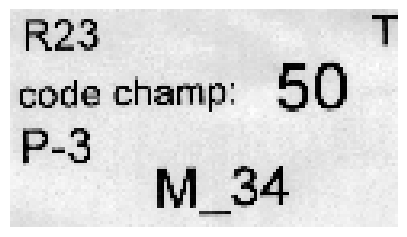

In [4]:
img = cv2.imread("../1.jpg")

R, P, code_champ, M, EPO, text_box_result, processing_time = process_image(img, reader, compression_ratio = 0.92)

print(f"R : {R}")
print(f"code champ : {code_champ}")
print(f"P : {P}")
print(f"M : {M}")
print(f"EPO : {EPO}")
print(f"Processing time: {processing_time:.3f} seconds")

plt.figure(figsize=(5, 5))
plt.imshow(text_box_result,cmap='gray')
plt.axis('off')
plt.show()